In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random
import json
from deap import base, creator, tools
from tensorflow.keras.callbacks import EarlyStopping


warnings.filterwarnings('ignore')

# =============================
# تحميل النموذج المدرب مسبقًا
# =============================

In [ ]:

print("بدء تحميل النموذج المدرب 'best_model_g.keras'...")
model = tf.keras.models.load_model('best_model_g.keras')
print("تم تحميل النموذج بنجاح.")
model.summary()


بدء تحميل النموذج المدرب 'best_model_g.keras'...
تم تحميل النموذج بنجاح.
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_402 (Conv2D)          (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization_536 (Bat (None, 128, 128, 128)     512       
_________________________________________________________________
activation_402 (Activation)  (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_403 (Conv2D)          (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_537 (Bat (None, 128, 128, 128)     512       
_________________________________________________________________
activation_403 (Activation)  (None, 128, 128, 128)     0         
______________________________________________

# =============================
# تحميل بيانات الصور من الملف
# =============================

In [ ]:

print("\nبدء تحميل بيانات الصور من الملف 'Segmented_data.npz'...")
data = np.load('Segmented_data.npz')

# استرجاع المصفوفات
x_train = data['x_train']
y_train = data['y_train']
x_val   = data['x_val']
y_val   = data['y_val']
x_test  = data['x_test']
y_test  = data['y_test']
class_names = data['class_names']
num_classes = data['num_classes']

print("تم تحميل البيانات.")
print("Class names:", class_names, "num_classes", num_classes)
print(f"عدد عينات التدريب المختارة: {x_train.shape[0]}")
print(f"عدد عينات التحقق المختارة: {x_val.shape[0]}")
print(f"عدد عينات الاختبار المختارة: {x_test.shape[0]}")

# تحويل التصنيفات من One-Hot إلى أعداد صحيحة
print("\nتحويل التصنيفات من One-Hot إلى أعداد صحيحة...")
y_train = np.argmax(y_train, axis=1)
y_val   = np.argmax(y_val, axis=1)
y_test  = np.argmax(y_test, axis=1)
print("تم تحويل التصنيفات.")



بدء تحميل بيانات الصور من الملف 'Segmented_data.npz'...
تم تحميل البيانات.
Class names: ['CRVO' 'DME' 'OTHER'] num_classes 3
عدد عينات التدريب المختارة: 3190
عدد عينات التحقق المختارة: 684
عدد عينات الاختبار المختارة: 684

تحويل التصنيفات من One-Hot إلى أعداد صحيحة...
تم تحويل التصنيفات.


# =============================
# استخراج الميزات باستخدام النموذج (feature extractor)
# =============================

In [4]:

print("\nإنشاء مستخرج الميزات من النموذج...")
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
print("تم إنشاء مستخرج الميزات.")

print("\nاستخراج الميزات من بيانات التدريب، التحقق والاختبار...")
train_features = feature_extractor.predict(x_train)
val_features   = feature_extractor.predict(x_val)
test_features  = feature_extractor.predict(x_test)
print("شكل ميزات التدريب:", train_features.shape)
print("شكل ميزات التحقق:", val_features.shape)
print("شكل ميزات الاختبار:", test_features.shape)



إنشاء مستخرج الميزات من النموذج...
تم إنشاء مستخرج الميزات.

استخراج الميزات من بيانات التدريب، التحقق والاختبار...
شكل ميزات التدريب: (3190, 64)
شكل ميزات التحقق: (684, 64)
شكل ميزات الاختبار: (684, 64)


# =============================
# تعريف دالة التقييم SVM
# =============================

In [5]:

def evaluate_fitness(mask):
    # تطبيق القناع على الميزات (اختيار الميزات المحددة فقط)
    masked_train = train_features[:, mask == 1]
    masked_val   = val_features[:, mask == 1]
    if masked_train.shape[1] == 0:
        return 0  # إذا لم يتم اختيار أي ميزات، نرجع ملاءمة صفرية
    clf = SVC(kernel='linear', C=1.0)  # يمكن تعديل معامل C إذا لزم الأمر
    clf.fit(masked_train, y_train)
    accuracy = clf.score(masked_val, y_val)
    return accuracy
print("تم تعريف دالة تقييم الملاءمة.")

تم تعريف دالة تقييم الملاءمة.


# =============================
# إعداد معاملات خوارزمية سرب الدلافين (مع ضبط المعاملات للحصول على أفضل تحسين)
# =============================

In [ ]:
import numpy as np


print("\nتهيئة معاملات خوارزمية سرب الدلافين (ضبط محسّن)...")
num_dolphins = 30    # عدد الدلافين في السرب
num_features = train_features.shape[1]  # عدد الميزات المستخرجة من النموذج
max_iters = 50         # عدد التكرارات
M = 8               # عدد الاتجاهات التي يتم البحث فيها لكل دولفين
T1 = 10              # الحد الأقصى لعدد مرات البحث
speed = 2             # سرعة انتشار الإشارة
A = 5                 # معامل التسارع لنقل الإشارات
e = 5                # معامل تقليل نصف قطر الحصار
R1=T1*speed           # نصف قطر الاحاطة
# تهيئة السرب عشوائيًا: كل دولفين يمثل قناع ميزات ثنائي (0 و1)
population = np.random.randint(0, 2, size=(num_dolphins, num_features), dtype=np.int32)
print("تم تهيئة السرب عشوائيًا.")

# ضمان أن كل دولفين يختار على الأقل ميزة واحدة
for i in range(num_dolphins):
    if not population[i].any():
        rand_index = np.random.randint(0, num_features)
        population[i, rand_index] = 1
print("تم التأكد من اختيار كل دولفين لميزة واحدة على الأقل.")

print("\nحساب الملاءمة الأولية لكل دولفين...")
fitness = np.array([evaluate_fitness(ind) for ind in population])
print("ملاءمات السكان:", fitness)
DD = np.linalg.norm(population[:, None] - population, axis=2)
TS = np.ceil(DD / (A * speed)).astype(int)
# تتبع أفضل حل فردي لكل دولفين وأفضل حل عالمي
personal_best_masks = population.copy()
personal_best_scores = fitness.copy()
best_idx = np.argmax(fitness)
global_best_mask = population[best_idx].copy()
global_best_score = fitness[best_idx]
print("أفضل ملاءمة أولية:", global_best_score)


تهيئة معاملات خوارزمية سرب الدلافين (ضبط محسّن)...
تم تهيئة السرب عشوائيًا.
تم التأكد من اختيار كل دولفين لميزة واحدة على الأقل.

حساب الملاءمة الأولية لكل دولفين...
ملاءمات السكان: [0.91812865 0.92251462 0.91959064 0.92397661 0.91812865 0.92105263
 0.91520468 0.92105263 0.92397661 0.91959064 0.93274854 0.92105263
 0.92397661 0.91081871 0.92251462 0.91812865 0.92397661 0.91520468
 0.9254386  0.92982456 0.92836257 0.92690058 0.92397661 0.92690058
 0.91666667 0.92251462 0.92105263 0.92251462 0.91959064 0.91374269]
أفضل ملاءمة أولية: 0.9327485380116959


# =============================
# تطبيق خوارزمية سرب الدلافين
# =============================

In [ ]:

print("\nبدء تطبيق خوارزمية سرب الدلافين...")
for iteration in range(max_iters):
    print(f"\n--- التكرار {iteration+1}/{max_iters} ---")

    # حساب المسافات بين الدلافين وأفضل الحلول
    DD = np.linalg.norm(population[:, None] - population, axis=2)  
    DK = np.linalg.norm(population - global_best_mask, axis=1) 
    DKLi = np.linalg.norm(personal_best_masks - global_best_mask, axis=1)  

    # مرحلة البحث: إرسال إشارات صوتية في M اتجاهات وتحديد أفضل اتجاه
    for i in range(num_dolphins):
        candidate_solutions = []
        candidate_scores = []

        for _ in range(M):
            num_flip = max(1, int(0.2 * num_features))
            flip_indices = np.random.choice(num_features, size=num_flip, replace=False)
            candidate_mask = population[i].copy()
            candidate_mask[flip_indices] = 1 - candidate_mask[flip_indices]
            candidate_solutions.append(candidate_mask)
            candidate_scores.append(evaluate_fitness(candidate_mask))

        best_candidate_idx = np.argmax(candidate_scores)
        candidate_mask = candidate_solutions[best_candidate_idx]
        candidate_fitness = candidate_scores[best_candidate_idx]

        if candidate_fitness > personal_best_scores[i]:
            personal_best_scores[i] = candidate_fitness
            personal_best_masks[i] = candidate_mask
            print(f"دولفين {i}: تم تحسين الحل الفردي إلى {candidate_fitness:.4f}")
            if candidate_fitness > global_best_score:
                global_best_score = candidate_fitness
                global_best_mask = candidate_mask.copy()
                print(f"تم تحديث أفضل حل عالمي إلى {global_best_score:.4f}")

    # مرحلة النداء والاستقبال: تحديث مصفوفة النقل وتبادل المعلومات
    # تقليل الزمن
    TS -= 1
    TS[TS < 0] = 0

    # استقبال: إذا TS[i, j] == 0 و j عنده حل أفضل → i ياخذ حل j
    for i in range(num_dolphins):
        for j in range(num_dolphins):
            if TS[i, j] == 0 and fitness[j] > fitness[i]:
                population[i] = population[j].copy()
                fitness[i] = fitness[j]
                TS[i, j] = np.ceil(DD[i, j] / (A * speed)).astype(int)

    # مرحلة الافتراس: تحريك الدلافين تجاه الحل الأفضل باستخدام نصف قطر الحصار R2
    for i in range(num_dolphins):
        if DK[i] <= R1:
            base = 1 - 2 / np.e
            R2 = base * DK[i]
            qq=0
        elif DK[i] >= DKLi[i]:                    
            f_k = global_best_score
            f_l = personal_best_scores[i]
            numerator = (DK[i] / f_k  ) + ((DK[i] - DKLi[i]) /  f_l)
            denominator = e * DK[i] * (1 / f_k)
            R2 = (1 - (numerator / denominator)) * DK[i]
            qq=1
        else:
            f_k = global_best_score
            f_l = personal_best_scores[i]
            numerator = (DK[i] / f_k  ) + ((DKLi[i]-DK[i]) /  f_l)
            denominator = e * DK[i] * (1 / f_k)
            R2 = (1 - (numerator / denominator)) * DK[i]
            qq=1
        if qq==1:
            random_vector = np.random.uniform(-1, 1, size=num_features)
            random_direction = random_vector / (np.linalg.norm(random_vector) + 1e-10)  # تجنب القسمة على صفر
            move_direction = personal_best_masks[i] + random_direction * R2 
        else :
            direction = population[i] - personal_best_masks[i]
            norm_direction = direction / DK[i]
            move_direction = personal_best_masks[i] + norm_direction * R2
        
                    # تحويل move_direction إلى احتمالات باستخدام sigmoid
        probabilities = 1 / (1 + np.exp(-move_direction))

        # توليد القناع الجديد بناءً على هذه الاحتمالات
        new_mask = np.where(np.random.rand(num_features) < probabilities, 1, personal_best_masks[i])
        
        if not new_mask.any():
            new_mask[np.random.randint(0, num_features)] = 1

        # تحديث الحلول
        new_fitness = evaluate_fitness(new_mask)
        if new_fitness > personal_best_scores[i]:
            personal_best_scores[i] = new_fitness
            personal_best_masks[i] = new_mask.copy()
            if new_fitness > global_best_score:
                global_best_score = new_fitness
                global_best_mask = new_mask.copy()
                print(f"تم تحديث أفضل حل عالمي إلى {global_best_score:.4f}")

    print(f"أفضل ملاءمة بعد التكرار {iteration+1}: {global_best_score:.4f}")

print("\nانتهت خوارزمية سرب الدلافين.")
print("أفضل دقة تم تحقيقها على بيانات التحقق:", global_best_score)
print("عدد الميزات المختارة:", np.sum(global_best_mask))



بدء تطبيق خوارزمية سرب الدلافين...

--- التكرار 1/50 ---
دولفين 0: تم تحسين الحل الفردي إلى 0.9225
دولفين 1: تم تحسين الحل الفردي إلى 0.9269
دولفين 2: تم تحسين الحل الفردي إلى 0.9240
دولفين 3: تم تحسين الحل الفردي إلى 0.9269
دولفين 4: تم تحسين الحل الفردي إلى 0.9254
دولفين 5: تم تحسين الحل الفردي إلى 0.9240
دولفين 6: تم تحسين الحل الفردي إلى 0.9269
دولفين 7: تم تحسين الحل الفردي إلى 0.9269
دولفين 8: تم تحسين الحل الفردي إلى 0.9254
دولفين 9: تم تحسين الحل الفردي إلى 0.9211
دولفين 12: تم تحسين الحل الفردي إلى 0.9254
دولفين 13: تم تحسين الحل الفردي إلى 0.9254
دولفين 14: تم تحسين الحل الفردي إلى 0.9298
دولفين 15: تم تحسين الحل الفردي إلى 0.9269
دولفين 16: تم تحسين الحل الفردي إلى 0.9342
تم تحديث أفضل حل عالمي إلى 0.9342
دولفين 17: تم تحسين الحل الفردي إلى 0.9225
دولفين 18: تم تحسين الحل الفردي إلى 0.9298
دولفين 19: تم تحسين الحل الفردي إلى 0.9342
دولفين 20: تم تحسين الحل الفردي إلى 0.9313
دولفين 21: تم تحسين الحل الفردي إلى 0.9298
دولفين 22: تم تحسين الحل الفردي إلى 0.9313
دولفين 24: تم ت

# =============================
# استخراج الميزات المختارة من بيانات الاختبار
# =============================

In [9]:

print("\nحجم الفيجرات قبل التقليص:")
print("بيانات التدريب:", train_features.shape)
print("بيانات الاختبار:", test_features.shape)
print("بيانات التحقق:", val_features.shape)

print("\nاستخراج الميزات المختارة من بيانات الاختبار...")
selected_indices = np.where(global_best_mask == 1)[0]
X_train_selected = train_features[:, selected_indices]
X_test_selected  = test_features[:, selected_indices]
X_val_selected  = val_features[:, selected_indices]

print("\nعدد الميزات المختارة:", len(selected_indices))
print("\nحجم الفيجرات بعد التقليص:")
print("بيانات التدريب:", X_train_selected.shape)
print("بيانات الاختبار:", X_test_selected.shape)
print("بيانات التحقق:", X_val_selected.shape)

print("\nتدريب المصنف النهائي باستخدام SVC على الميزات المختارة...")
clf_final = SVC(kernel='linear', C=1.0)
clf_final.fit(X_train_selected, y_train)
predictions = clf_final.predict(X_val_selected)

# حساب دقة التصنيف النهائية
final_accuracy = accuracy_score(y_val, predictions)
print("\nدقة التصنيف النهائية على بيانات التحقق باستخدام الميزات المختارة:", final_accuracy)
np.save('selected_indices.npy', selected_indices)



حجم الفيجرات قبل التقليص:
بيانات التدريب: (3190, 64)
بيانات الاختبار: (684, 64)
بيانات التحقق: (684, 64)

استخراج الميزات المختارة من بيانات الاختبار...

عدد الميزات المختارة: 36

حجم الفيجرات بعد التقليص:
بيانات التدريب: (3190, 36)
بيانات الاختبار: (684, 36)
بيانات التحقق: (684, 36)

تدريب المصنف النهائي باستخدام SVC على الميزات المختارة...

دقة التصنيف النهائية على بيانات التحقق باستخدام الميزات المختارة: 0.9400584795321637


Classification Report:
               precision    recall  f1-score   support

        CRVO       0.96      0.91      0.94       235
         DME       0.91      0.96      0.93       240
       OTHER       0.96      0.94      0.95       209

    accuracy                           0.94       684
   macro avg       0.94      0.94      0.94       684
weighted avg       0.94      0.94      0.94       684



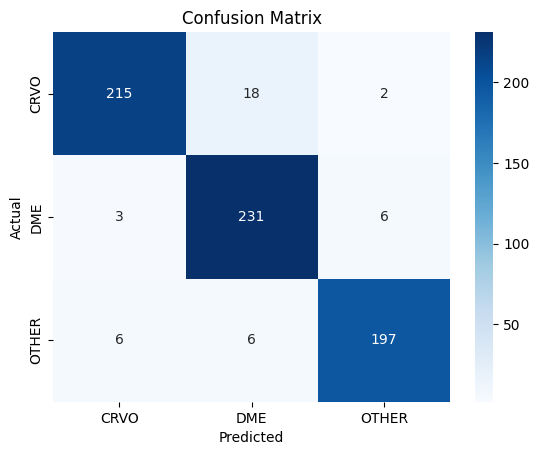

Model Accuracy: 0.94006


In [10]:
# التنبؤ باستخدام المصنف النهائي على بيانات التحقق (بعد اختيار الميزات)
y_pred = clf_final.predict(X_val_selected)

# تحويل المخرجات إلى فئات إذا كانت النتائج بصيغة one-hot
# إذا كانت y_pred أو y_val عبارة عن مصفوفات ذات بُعدين (one-hot)، يتم استخدام np.argmax
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred
y_true = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val

# طباعة التقرير التصنيفي مع أسماء الفئات (class_names)
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# حساب مصفوفة الالتباس
cm = confusion_matrix(y_true, y_pred_classes)

# رسم مصفوفة الالتباس باستخدام seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
# حساب الدقة بدقة الأعشار
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.5f}")  # طباعة الدقة حتى منزلة عشرية واحدة

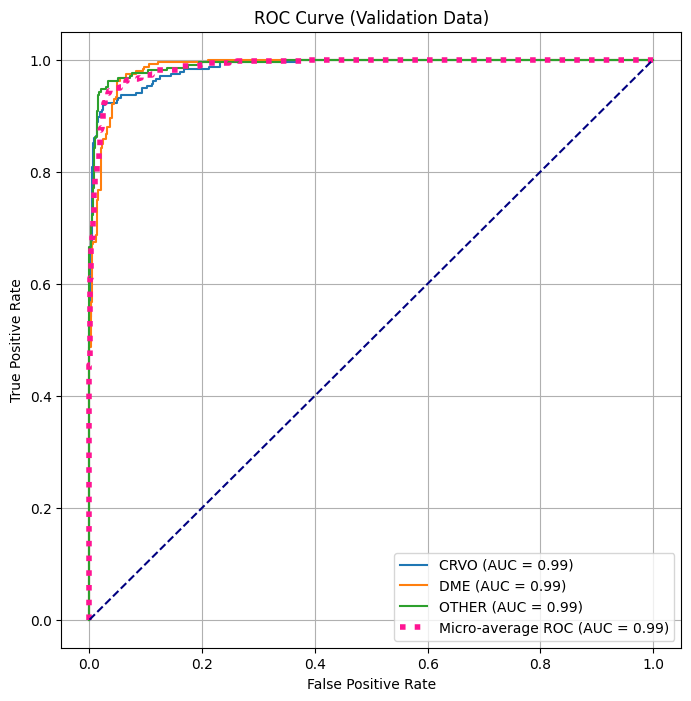

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.svm import SVC

# إنشاء نموذج SVC مع تمكين حساب الاحتمالات
clf_final = SVC(kernel='linear', C=1.0, probability=True)
clf_final.fit(X_train_selected, y_train)

# الآن يمكنك الحصول على احتمالات التنبؤ
y_val_pred = clf_final.predict_proba(X_val_selected)

# تأكد من تعريف أسماء الفئات بشكل مناسب
# مثال:
# class_names = ['الفئة 0', 'الفئة 1', 'الفئة 2', ...]

# تحويل y_val إلى ترميز one-hot إذا كانت على شكل أرقام
if len(y_val.shape) == 1:
    y_val_onehot = label_binarize(y_val, classes=np.arange(len(class_names)))
else:
    y_val_onehot = y_val

# الحصول على احتمالات التنبؤ من النموذج باستخدام predict_proba
# تأكد أن النموذج clf_final تم تهيئته بـ probability=True
y_val_pred = clf_final.predict_proba(X_val_selected)

# عدد الفئات
n_classes = y_val_onehot.shape[1]

# حساب منحنى ROC و AUC لكل فئة
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_onehot[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# حساب ROC والـ AUC للمعدل الكلي (micro-average)
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_onehot.ravel(), y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# رسم منحنيات ROC
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# إضافة منحنى الميكرو
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
    color="deeppink", linestyle=":", linewidth=4
)

# رسم خط القاعدة (خط العشوائية)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve (Validation Data)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Classification Report:
               precision    recall  f1-score   support

        CRVO       0.96      0.90      0.93       235
         DME       0.93      0.97      0.95       240
       OTHER       0.91      0.92      0.92       209

    accuracy                           0.93       684
   macro avg       0.93      0.93      0.93       684
weighted avg       0.93      0.93      0.93       684



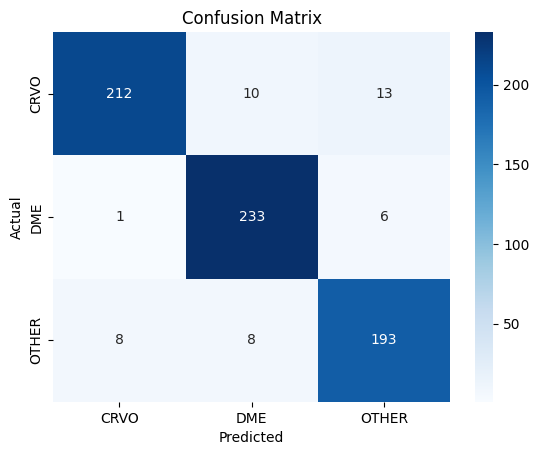

Model Accuracy: 0.93275


In [12]:
# التنبؤ باستخدام المصنف النهائي على بيانات التحقق (بعد اختيار الميزات)
y_pred = clf_final.predict(X_test_selected)

# تحويل المخرجات إلى فئات إذا كانت النتائج بصيغة one-hot
# إذا كانت y_pred أو y_val عبارة عن مصفوفات ذات بُعدين (one-hot)، يتم استخدام np.argmax
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# طباعة التقرير التصنيفي مع أسماء الفئات (class_names)
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# حساب مصفوفة الالتباس
cm = confusion_matrix(y_true, y_pred_classes)

# رسم مصفوفة الالتباس باستخدام seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# حساب الدقة بدقة الأعشار
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.5f}")  # طباعة الدقة حتى منزلة عشرية واحدة


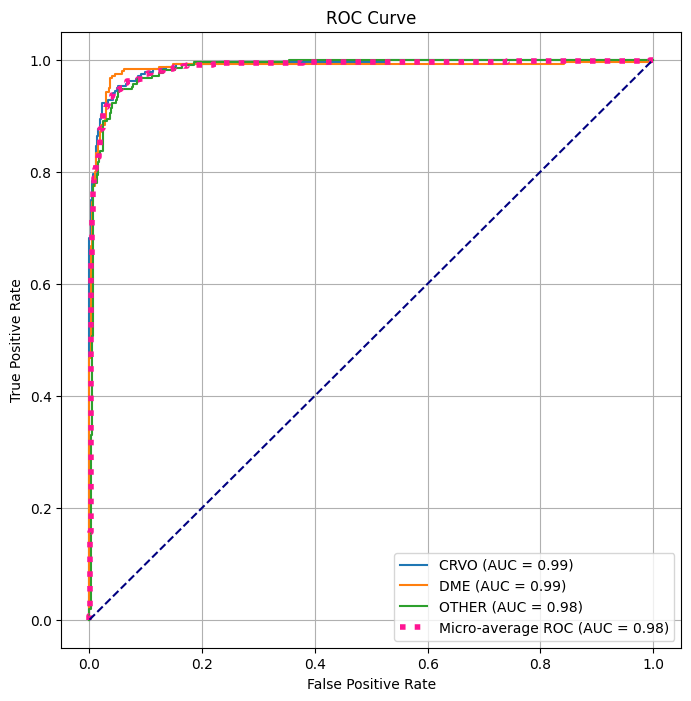

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.svm import SVC


# إنشاء نموذج SVC مع تمكين حساب الاحتمالات
clf_final = SVC(kernel='linear', C=1.0, probability=True)
clf_final.fit(X_train_selected, y_train)
# الحصول على احتمالات التنبؤ على بيانات الاختبار
y_test_pred = clf_final.predict_proba(X_test_selected)

# تأكد من تعريف أسماء الفئات بشكل مناسب
# مثال:
# class_names = ['الفئة 0', 'الفئة 1', 'الفئة 2', ...]

# تحويل y_test إلى ترميز one-hot إذا كانت على شكل أرقام
if len(y_test.shape) == 1:
    y_test_onehot = label_binarize(y_test, classes=np.arange(len(class_names)))
else:
    y_test_onehot = y_test

# عدد الفئات
n_classes = y_test_onehot.shape[1]

# حساب منحنى ROC و AUC لكل فئة
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# حساب ROC والـ AUC للمعدل الكلي (micro-average)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# رسم منحنيات ROC
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# إضافة منحنى الميكرو
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
    color="deeppink", linestyle=":", linewidth=4
)

# خط القاعدة
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [15]:
import joblib
joblib.dump(clf_final, 'Final_model.pkl')


['Final_model.pkl']

In [16]:
clf_final = joblib.load('Final_model.pkl')
